In [1]:
import json
import numpy as np
import pandas as pd
from collections import OrderedDict
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms, models, datasets, utils
from torchsummary import summary
from PIL import Image
import memory_profiler  # conda install -c anaconda memory_profiler
import matplotlib.pyplot as plt
from torch.utils.data import SubsetRandomSampler

In [2]:
import os
os.getcwd()

'C:\\Users\\szyan\\Documents\\Capstone'

In [3]:
TRAIN_DIR = "data/train/"

mem = memory_profiler.memory_usage()[0]
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR)
print(f"Memory consumed: {memory_profiler.memory_usage()[0] - mem:.0f} mb") #no memory consumed yet

Memory consumed: 0 mb


In [4]:
#summary of the training set
print(f"Classes: {train_dataset.classes}")
print(f"Class count: {train_dataset.targets.count(0)}, {train_dataset.targets.count(1)}")
print(f"Samples:",len(train_dataset))
print(f"First sample: {train_dataset.samples[0]}")

Classes: ['negative', 'positive']
Class count: 89, 94
Samples: 183
First sample: ('data/train/negative\\USLH001_01.png', 0)


Class: positive


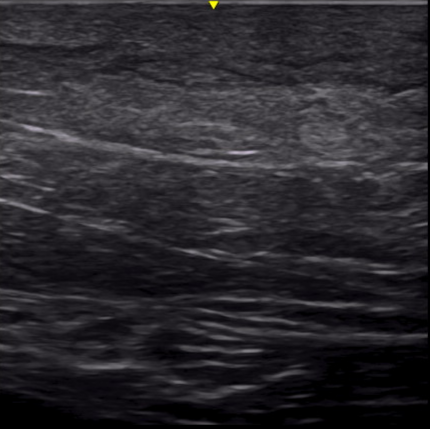

In [5]:
#One image example
img, target = train_dataset[105]
print(f"Class: {train_dataset.classes[target]}")
img

In [6]:
#Image example info
print(f"Image data type: {type(img)}")
print(f"     Image size: {img.size}")

Image data type: <class 'PIL.Image.Image'>
     Image size: (430, 429)


In [7]:
#transform

IMAGE_SIZE = 300
BATCH_SIZE = 8

train_transforms = transforms.Compose([
     transforms.RandomVerticalFlip(p=0.5),
     transforms.RandomRotation(degrees=20),
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR,
                                                 transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           drop_last=False)
imgs, targets = next(iter(train_loader))
print(f"       # of batches: {len(train_loader)}")
print(f"    Image data type: {type(imgs)}")
print(f"   Image batch size: {imgs.shape}")  # dimensions are (batch size, image channels, image height, image width)
print(f"  Target batch size: {targets.shape}")
print(f"       Batch memory: {memory_profiler.memory_usage()[0] - mem:.2f} mb")  # memory usage after loading batch


       # of batches: 23
    Image data type: <class 'torch.Tensor'>
   Image batch size: torch.Size([8, 3, 300, 300])
  Target batch size: torch.Size([8])
       Batch memory: 15.75 mb


In [8]:
#load densenet and adjust classifier layer

densenet = models.densenet121(pretrained=True)

new_layers = nn.Sequential(OrderedDict([
    ('new1', nn.Linear(1024, 500)),
    ('relu', nn.ReLU()),
    ('new2', nn.Linear(500, 1))
]))
densenet.classifier = new_layers

#weight initialization
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        print("Initializing weights of a Conv2d layer!")
        nn.init.normal_(m.weight, mean=0, std=0.1)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d): 
        print("Initializing weights of a batchnorm layer!")
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        print("Initializing weights of a Linear layer!")
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)
        
torch.manual_seed(2021)
densenet.apply(weights_init);

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
densenet.to(device);

Initializing weights of a Conv2d layer!
Initializing weights of a batchnorm layer!
Initializing weights of a batchnorm layer!
Initializing weights of a Conv2d layer!
Initializing weights of a batchnorm layer!
Initializing weights of a Conv2d layer!
Initializing weights of a batchnorm layer!
Initializing weights of a Conv2d layer!
Initializing weights of a batchnorm layer!
Initializing weights of a Conv2d layer!
Initializing weights of a batchnorm layer!
Initializing weights of a Conv2d layer!
Initializing weights of a batchnorm layer!
Initializing weights of a Conv2d layer!
Initializing weights of a batchnorm layer!
Initializing weights of a Conv2d layer!
Initializing weights of a batchnorm layer!
Initializing weights of a Conv2d layer!
Initializing weights of a batchnorm layer!
Initializing weights of a Conv2d layer!
Initializing weights of a batchnorm layer!
Initializing weights of a Conv2d layer!
Initializing weights of a batchnorm layer!
Initializing weights of a Conv2d layer!
Init

In [9]:
#load
IMAGE_SIZE = 300
BATCH_SIZE = 8

VALID_DIR = "data/val/"

valid_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor()
])

# New dataloaders
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataset = torchvision.datasets.ImageFolder(root=VALID_DIR, transform=valid_transforms)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

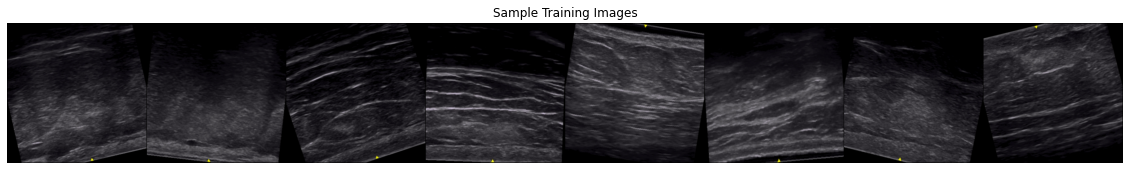

In [10]:
# Get one batch
imgs, targets = next(iter(train_loader))

# plot the samples
plt.figure(figsize=(20, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(imgs, padding=1, normalize=True),(1, 2, 0)));

In [11]:
# apply a transformation to improve the contrast 
comb = [transforms.functional.adjust_contrast(i, contrast_factor = 1.5) for i in imgs]

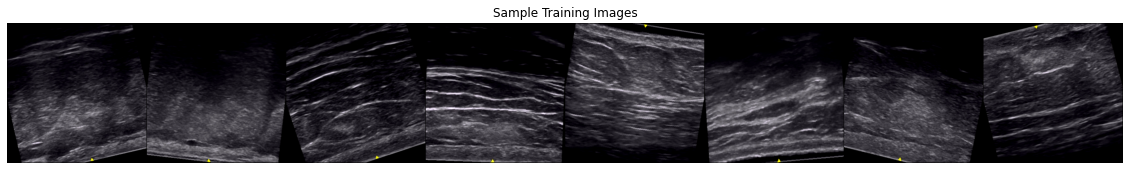

In [12]:
# plot the samples
plt.figure(figsize=(20, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(comb, padding=1, normalize=True),(1, 2, 0)));

In [13]:
def trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_accuracy = []
    valid_accuracy = []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in train_loader:
            if device.type == 'cuda':
                X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X).flatten()
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            loss = criterion(y_hat, y.type(torch.float32))
            loss.backward()
            optimizer.step()
            train_batch_loss += loss.item()
            train_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()
        train_accuracy.append(train_batch_acc / len(train_loader))
        
        # Validation
        confusion_matrix = torch.zeros(2, 2)
        model.eval()
        with torch.no_grad():
            for X, y in valid_loader:
                if device.type == 'cuda':
                    X, y = X.to(device), y.to(device)
                y_hat = model(X).flatten()
                y_hat_labels = torch.sigmoid(y_hat) > 0.5
                loss = criterion(y_hat, y.type(torch.float32))
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()
        valid_accuracy.append(valid_batch_acc / len(valid_loader))
        
        with torch.no_grad():
            for i, (inputs, classes) in enumerate(valid_loader):
                inputs = inputs.to(device)
                classes = classes.to(device)
                outputs = densenet(inputs).flatten()
                preds = torch.sigmoid(outputs) > 0.5
                for t, p in zip(classes.view(-1), preds.view(-1)):
                        confusion_matrix[t.long(), p.long()] += 1
        recall = confusion_matrix.numpy()[1,1]/(confusion_matrix.numpy()[1,1]+confusion_matrix.numpy()[1,0])
        model.train()
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.",
                  f"Valid Recall: {recall:.2f}")
    
    return {"train_accuracy": train_accuracy, "valid_accuracy": valid_accuracy, "Valid_recall":recall}

In [14]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(densenet.parameters())
results = trainer(densenet, criterion, optimizer, train_loader, valid_loader, device, epochs=24)

Epoch 1: Train Accuracy: 0.66. Valid Accuracy: 0.31. Valid Recall: 0.35
Epoch 2: Train Accuracy: 0.80. Valid Accuracy: 0.49. Valid Recall: 0.00
Epoch 3: Train Accuracy: 0.78. Valid Accuracy: 0.64. Valid Recall: 0.45
Epoch 4: Train Accuracy: 0.78. Valid Accuracy: 0.65. Valid Recall: 1.00
Epoch 5: Train Accuracy: 0.73. Valid Accuracy: 0.72. Valid Recall: 0.65
Epoch 6: Train Accuracy: 0.81. Valid Accuracy: 0.51. Valid Recall: 0.05
Epoch 7: Train Accuracy: 0.75. Valid Accuracy: 0.69. Valid Recall: 1.00
Epoch 8: Train Accuracy: 0.79. Valid Accuracy: 0.74. Valid Recall: 0.70
Epoch 9: Train Accuracy: 0.82. Valid Accuracy: 0.64. Valid Recall: 0.50
Epoch 10: Train Accuracy: 0.76. Valid Accuracy: 0.82. Valid Recall: 0.90
Epoch 11: Train Accuracy: 0.79. Valid Accuracy: 0.79. Valid Recall: 0.80
Epoch 12: Train Accuracy: 0.82. Valid Accuracy: 0.74. Valid Recall: 1.00
Epoch 13: Train Accuracy: 0.83. Valid Accuracy: 0.80. Valid Recall: 0.75
Epoch 14: Train Accuracy: 0.83. Valid Accuracy: 0.61. Valid 

In [15]:
#load one positive example
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR)
img, target = train_dataset[105]
image_tensor = transforms.functional.to_tensor(img.resize((300, 300))).unsqueeze(0)

In [16]:
#move to cpu for visualization
densenet1 = densenet.cpu()

In [17]:
prediction = int(torch.sigmoid(densenet(image_tensor)) > 0.5)
print(f"Prediction: {train_dataset.classes[prediction]}")

Prediction: positive


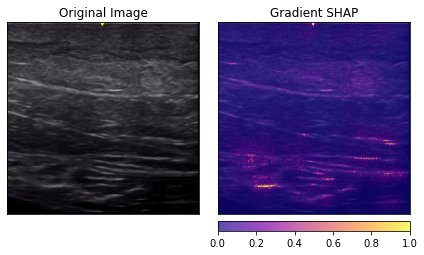

In [18]:
#feature importance
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import visualization as viz


torch.manual_seed(2021); np.random.seed(2021)
gradient_shap = GradientShap(densenet1)
rand_img_dist = torch.cat([image_tensor * 0, image_tensor * 1])
attributions_gs = gradient_shap.attribute(image_tensor,
                                          n_samples=20,
                                          stdevs=0.15,
                                          baselines=rand_img_dist,
                                          target=0)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().detach().numpy(), (1,2,0)),
                                      np.transpose(image_tensor.squeeze().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "absolute_value"],
                                      titles = ["Original Image", "Gradient SHAP"],
                                      cmap="plasma",
                                      show_colorbar=True,
                                      fig_size=(6, 6),
                                      alpha_overlay=0.7)

In [19]:
TEST_DIR = "data/test/"
test_dataset = torchvision.datasets.ImageFolder(root=TEST_DIR, transform=valid_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
#get test accuracy
def get_test_accuracy(cnn, data_loader):
    test_accuracy = []
    cnn = cnn.cuda()
    test_batch_loss = 0
    test_batch_acc = 0
    cnn.eval()
    with torch.no_grad():
        for X, y in data_loader:
            if device.type == 'cuda':
                X, y = X.to(device), y.to(device)
            y_hat = cnn(X).flatten()
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            test_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()
    test_accuracy.append(test_batch_acc / len(data_loader))
    return test_accuracy[-1]

In [21]:
get_test_accuracy(densenet, test_loader)

0.75

In [22]:
#confusion matrix
def pytorch_confusion_matrix(nb_classes, cnn, data_loader):

    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(data_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = cnn(inputs).flatten()
            preds = torch.sigmoid(outputs) > 0.5
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    cm = pd.DataFrame(confusion_matrix.numpy(), columns = ['predict negative','predict positive'], index = ['actual negative', 'actual positive'])
    return cm

In [23]:
cmtx = pytorch_confusion_matrix(2,densenet, test_loader)

In [24]:
cmtx

,predict negative,predict positive
actual negative,18.0,2.0
actual positive,10.0,11.0


In [25]:
#calculate test recall
def recall_calculation(confusion_matrix):
    return cmtx.iloc[1,1]/(cmtx.iloc[1,1]+cmtx.iloc[1,0])

In [26]:
recall_calculation(cmtx)

0.52380955

In [27]:
# occlusion = Occlusion(densenet1)
# attributions_occ = occlusion.attribute(image_tensor,
#                                        strides = (1, 3, 3),
#                                        sliding_window_shapes=(1, 10, 10),
#                                        baselines=0)
# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().detach().numpy(), (1,2,0)),
#                                       np.transpose(image_tensor.squeeze().detach().numpy(), (1,2,0)),
#                                       ["original_image", "blended_heat_map"],
#                                       ["all", "positive"],
#                                       titles = ["Original Image", "Occlusion"],
#                                       cmap="plasma",
#                                       fig_size=(6, 6),
#                                       alpha_overlay=0.7
#                                      )